# Solution of faulkner-skan equations using 'Formulation - B'

#### Faulkner - Skan boundary layer equation:
$\begin{align}
f''' + \frac{(m+1)}{2}ff'' + m(1 - (f')^2) = 0
\end{align}$
where 
$$\eta  = y\left ( \sqrt\frac{U(x)}{\nu x} \right )$$
and
$$f'(\eta ) =\frac{u}{U(x)}$$

#### Boundary Conditions:
$$\eta = 0 : f(0) = f'(0) = 0$$
$$ \eta = 6 : f'(6) = 1 $$
$$ \eta = 6 : f''(6) = 0 $$
To represent infinity for computational purposes a sufficiently large number ($\eta = 6$) is taken 

### This is the implementation of solution of faulkner skan boundary layer equation using PIELM method

In [97]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim 
import numpy as np   # Numpy
import matplotlib.pyplot as plt

In [98]:
#Creation of 1D array (representing data sampling)
np.random.seed(941)
torch.manual_seed(551)
eta = np.linspace(0,6,1000)[:,None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

#ODE parametres
m =0           # this value of m can be changed and results for different wedge angles can be generated.
k = 1
nu = 1.48e-5    # kinematic viscosity of air

bc = eta[[0,-1]]
f_bc = np.array([[0],
                [1]])

In [99]:
eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

PIELM is different from PINNS , here the weights between input layer and hidden layer should be left untrained
and it does not uses backpropagation to update the weights

### Loss function formulation for PIELM :
#### Boundary Loss :
$$e_{bc1} = f(0) = 0$$
$$e_{bc2} = f'(0) = 0$$
$$e_{bc3} = f'(6)-1 = 0$$
$$e_{bc4} = f''(6) = 0$$
$e_{bc} = e_{bc1}^2+e_{bc2}^2+e_{bc3}^2+e_{bc4}^2$

#### ODE loss : 
$$e_{ode} = \frac{1}{N}\sum_{i=1}^{N}\left ( f''' +\frac{(m+1)}{2}ff''+m(1-(f')^2) \right )^2$$

#### Total Loss :
$$e_{total} = e_{bc} + e_{ode}$$

#### Now this total composite Loss function is optimised to get the weights between hidden layer and output layer

#### I used Automatic Differentiation to compute derivatives for optimization of loss function , to get weights (C)

In [100]:
class PIELM(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # defining the activation function
        self.activation = nn.Tanh()

        #defining the loss function
        self.loss_function = nn.MSELoss(reduction='mean')

       
        self.fc1 =nn.Linear(1,hidden_size)
        self.fc2 = nn.Linear(hidden_size,1,bias = False)   # No bias in between hidden layer and output layer.

        self.iter = 0


        self.Lbc = []
        self.Lpde = []


    def forward(self,x):

        # A check if input data is not in tensor form
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # min - max scaling of the data 
        x = (x -eta_min)/(eta_max-eta_min)

        
        z = self.fc1(x)
        a = self.activation(z)

        f = self.fc2(a)
        return f

    def bc_loss(self,x,y):
        
        # BC1
        x1 = x[[0]]
        y1 = y[[0]]

        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1,g1,torch.ones([x1.shape[0],1]),retain_graph = True,create_graph = True)[0]

        #BC2
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2,g2,torch.ones([x2.shape[0],1]),retain_graph = True,create_graph = True)[0]

        loss_bc1 = self.loss_function(f1,y1) + self.loss_function(f_etab1,torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2,y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc
    
    def PDE(self,x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)

        f_eta = autograd.grad(f3,g3,torch.ones([g3.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_eta2 = autograd.grad(f_eta,g3,torch.ones([g3.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_eta3 = autograd.grad(f_eta2,g3,torch.ones([g3.shape[0],1]),create_graph = True)[0]

        # defining faulkner skan ordinary differential equation
        
        pde = f_eta3 + ((m+1)/2) * f3*f_eta2 + m*(1 -(f_eta)**2)

        loss_pde = self.loss_function(pde,torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde
    
    # composite loss function to be optimised for PIELM to get C
    def loss(self,x,xb,yb):

        loss1= self.bc_loss(xb,yb)
        loss2 = self.PDE(x)

        total_loss = abs(loss1) + abs(loss2)
        return total_loss
    
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(eta,bc,f_bc)

        loss.backward()

        self.iter += 1

        if self.iter % 100 ==0:
            print(loss)
            
        return loss    
    
    def test(self,x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result,x,torch.ones([x.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_dd = autograd.grad(f_d,x,torch.ones([x.shape[0],1]),retain_graph = True,create_graph = True)[0]

        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()


        return pred_result,f_d,f_dd

In [101]:
# specification of network architecture
hidden_size = 20

#creating an instance of NN class
pielm = PIELM()

pielm.fc1.weight.requires_grad = False   # keeping the weights between input layer and hidden layer untrained
pielm.fc1.bias.requires_grad = False     # keeping the bias between input layer and hidden layer untrained

#params0 = list(pielm.parameters())


optimizer = torch.optim.LBFGS(pielm.parameters(),lr = 0.1,max_iter = 2000,
                              tolerance_grad = 1e-10,tolerance_change=1e-10,
                              history_size = 800,line_search_fn='strong_wolfe')

optimizer.step(pielm.closure)

tensor(0.0013, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)


tensor(1.1184, grad_fn=<AddBackward0>)

208


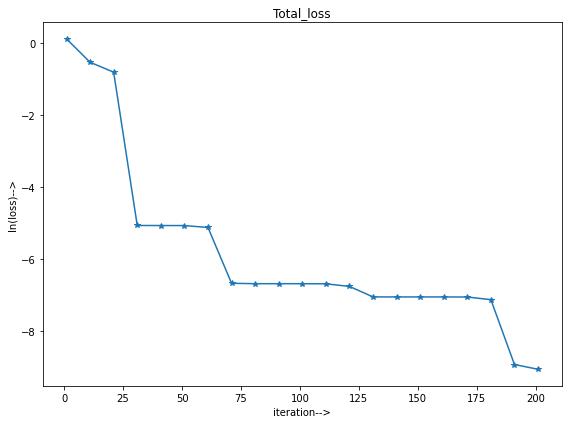

0.00011686138473976371


In [102]:
print(pielm.iter)
Lbc_list = pielm.Lbc
Lpde_list = pielm.Lpde

plt.figure(figsize = (8,6))
#plt.subplot(121)
#plt.plot(np.arange(1,len(Lbc_list)+1)[::10],np.log(np.array(Lbc_list)[::10]),marker = '*',label = 'boundary_loss')
#plt.plot(np.arange(1,len(Lpde_list)+1)[::10],np.log(np.array(Lpde_list)[::10]),marker = 'o',label = 'pde_loss')
#plt.legend()
#plt.xlabel('iteration-->')
#plt.ylabel('ln(loss)-->')
#plt.title('Indivisual_loss')

#plt.subplot(122)
total_loss = [a + b for a, b in zip(Lbc_list, Lpde_list)]
plt.plot(np.arange(1,len(total_loss)+1)[::10],np.log(np.array(total_loss)[::10]),marker ='*')
plt.title('Total_loss')
plt.xlabel('iteration-->')
plt.ylabel('ln(loss)-->')
plt.tight_layout()
#plt.savefig(f'Loss({layers[1]}).png')
plt.show()

error = abs(total_loss[-1])
print(error)
fp,fp_d,fp_dd = pielm.test(eta)

In [103]:
eta = eta.detach().numpy()
fp = fp[:,0]
fp_d = fp_d[:,0]
fp_dd = fp_dd[:,0]
eta = eta[:,0]

In [104]:
Lxfd = [0, 4.552160519570624, 3.066385984263268, 2.7502637427085115, 2.4088516253565224, 1.1570073558539828, 0.6512120105485026, 0.2212855690883295, 0.44889372771703223, 0.9167545005087937, 1.7702847938887667, 2.067439508004534, 1.4604849006922533, 3.83772406071117, 5.608008613417806, 3.445732674128976, 4.172813829704915, 4.893572636922612, 5.253952281713591, 5.987355303283514]
Lyfd = [0, 0.9751243793683977, 0.8557214509462848, 0.8026532578272146, 0.7363182694762745, 0.3847431348737711, 0.22553906161235535, 0.07960228967860679, 0.1525706756454806, 0.3117747489068963, 0.5704807985989241, 0.6500830882775309, 0.4776122197842463, 0.9485905358567606, 1.0016579698321355, 0.908789391017458, 0.9684904756566657, 0.9950250783119986, 1.0016579698321355, 1.0082918735438675]

Lxf = [0, 0.22712925402447556, 0.504731889543208, 0.7760252320376988, 1.1419560444964605, 1.533123066352511, 1.9305996219077235, 2.30914853906513, 2.7444794087162743, 3.1608836026692932, 3.5331229861275375, 3.880126160188493, 4.2586750773459, 4.624605889804661, 4.971609063865618, 5.305993651878089, 5.627760616541755, 5.993691429000518]
Lyf = [0, 0.01326730132766719, 0.039800891791404, 0.09950248252641035, 0.22553906161235535, 0.40464332772157463, 0.63018238933393, 0.8756221498898867, 1.174129344421218, 1.5323378766396556, 1.8573799268742182, 2.189054868628918, 2.5737977504547906, 2.9253731381051926, 3.2570480798598926, 3.608623467510295, 3.93366501164906, 4.305140908457139]

Lxfdd = [0, 0.2776023948438126, 0.5804414804347537, 0.858044115953486, 1.173501787592911, 1.5078863756053829, 1.835962392618372, 2.1703469806308435, 2.485804411595349, 2.8706623811020777, 3.217665555163032, 3.5962144723204386, 3.955836232429878, 4.359621840334413, 4.694006428346884, 5.034701031408358, 5.444795691662215, 5.987381895301356]
Lyfdd = [0.3316749417546999, 0.3316749417546999, 0.3316749417546999, 0.32504154413876474, 0.3117747489068963, 0.2918740499632959, 0.2719733510196945, 0.24543976055595673, 0.21890566399642114, 0.1791047722050162, 0.13930337431781434, 0.09950248252641035, 0.059701590735005396, 0.03316749417547075, 0.0265340965595356, 0.01326730132766719, 0.01326730132766719, 0.01326730132766719]

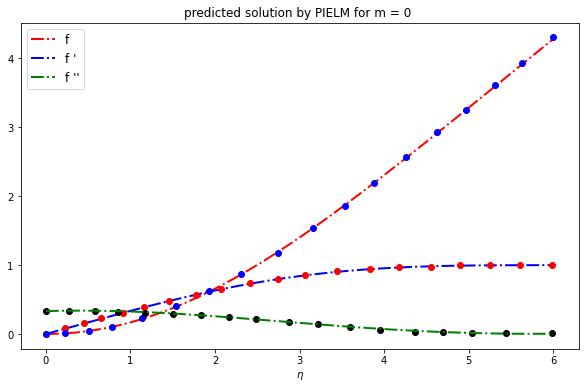

In [105]:
plt.figure(figsize =(10,6))
plt.plot(eta,fp,linestyle = '-.',label = 'f',c = 'red',linewidth = 2)
plt.plot(eta,fp_d,linestyle ='-.',label ="f '",c='blue',linewidth = 2)
plt.plot(Lxfd,Lyfd,'or')
plt.plot(Lxf,Lyf,'ob')
plt.plot(Lxfdd,Lyfdd,'ok')
plt.plot(eta,fp_dd,linestyle ='-.',label = "f ''",c = "green",linewidth = 2)
plt.title(f"predicted solution by PIELM for m = {m} ")
plt.xlabel('$\eta$')
plt.legend(fontsize = 12)


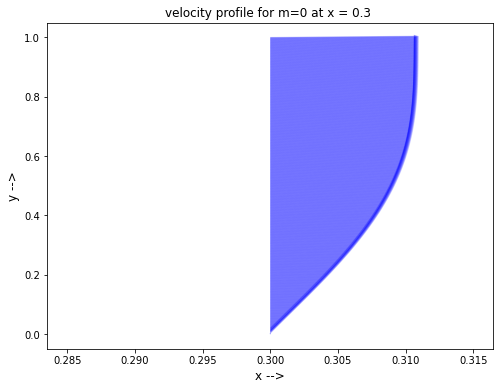

In [106]:
x_vel = 0.3
y_vel = np.linspace(0,1,1000)


u = k*x_vel**m*fp_d

v = (-1*(((m+1)/2)*nu*k*x_vel**(m-1))**0.5)*(fp + ((m-1)/(m+1))*eta*fp_d)

plt.figure(figsize = (8,6))
plt.quiver(np.ones(1000)*x_vel, y_vel, u, v, scale=3, color='b', alpha=0.2)
plt.title(f"velocity profile for m={m} at x = {x_vel} ")
plt.xlabel('x -->',fontsize = 12)
plt.ylabel('y -->',fontsize = 12)
plt.show()

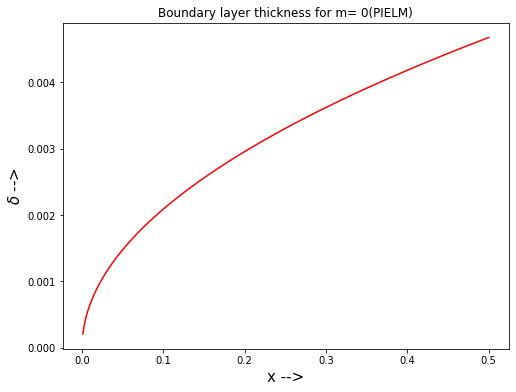

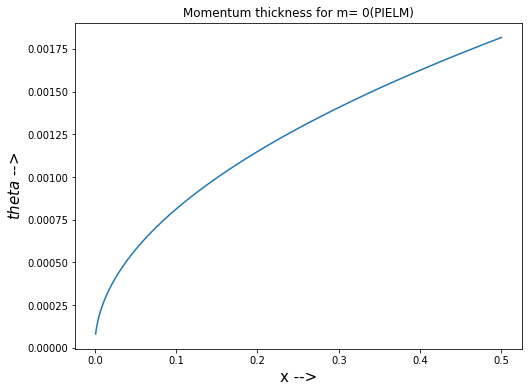

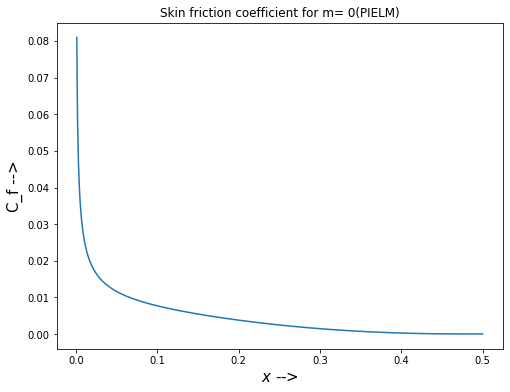

In [107]:
# defining local reynolds number
x_r = np.linspace(1e-3,0.5,1000)

Re_x = (k*(x_r**m)*x_r)/nu

integral_delta = np.trapz((1-fp_d), eta)

delta = x_r*np.sqrt(1/Re_x)*integral_delta

plt.figure(figsize = (8,6))
plt.plot(x_r,delta ,c="r" )
plt.xlabel("x -->",fontsize = 15)
plt.title(f'Boundary layer thickness for m= {m}(PIELM)')
plt.ylabel('$\delta$ -->',fontsize = 15)
plt.show()

integral_theta = np.trapz((fp_d*(1-fp_d)), eta)

theta_x = x_r*np.sqrt(1/Re_x)*integral_theta

plt.figure(figsize = (8,6))
plt.plot(x_r,theta_x)
plt.xlabel("x -->",fontsize = 15)
plt.title(f'Momentum thickness for m= {m}(PIELM)')
plt.ylabel('$theta$ -->',fontsize = 15)
plt.show()

c_f = (2*fp_dd)/np.sqrt(Re_x)

plt.figure(figsize = (8,6))
plt.plot(x_r,c_f)
plt.xlabel("$x$ -->",fontsize = 15)
plt.title(f'Skin friction coefficient for m= {m}(PIELM)')
plt.ylabel('C_f -->',fontsize = 15)
plt.show()

the main difference observed between PINN and PIELM is the speed of convergance . PINN is taking more no. of iterations to get to the solutions, whereas PIELM got optimized in few iterations.(if pseudoinverse approach is used it can be even faster).